In [1]:
from Helpers import *

In [2]:
def Feedback_Linearization(Duration,w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,30],plot = True,Noise_Variance = 1e-6,ForceField = [0,0],ForceFieldSpan = [0,0]):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noise in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)
    """

    Num_iter = 600
    dt = Duration/Num_iter 

    st1,st2 = newton(f,df,1e-8,1000,starting_point[0],starting_point[1])
    obj1,obj2 = newton(f,df,1e-8,1000,targets[0],targets[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06
    A = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Compute the Feedback Gain of the Control law
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 

    sigma = np.identity(Num_Var)*10**-6 
    H,L = np.identity(8),array_L

    #Initialize the arrays to stock the simulations 
    array_xhat = np.zeros((Num_iter,Num_Var))
    array_x_nonlin = np.zeros((Num_iter,Num_Var-2)) 
    y = np.zeros((Num_iter,Num_Var))

    #Initialize the state vectors of the linear system
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0)
    x_true = np.copy(x0)

    #Initialize the state vectors of the nonlinear system
    x_nonlin = np.zeros(Num_Var-2)
    x_nonlin[0],x_nonlin[1] = x0[0],x0[3]

    new_x_nonlin = np.copy(x_nonlin)
    x_nonlinhat = np.copy(x_nonlin)
    new_x_nonlinhat = np.copy(x_nonlin)

    #Perform the task

    for k in range(Num_iter-1):

        #Compute the matrices of the system in function of the current state 

        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else 0
        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
            
        C = np.array([-x_nonlin[3]*(2*x_nonlin[2]+x_nonlin[3])*a2*np.sin(x_nonlin[1]),x_nonlin[2]*x_nonlin[2]*a2*np.sin(x_nonlin[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(x_nonlin[1])*np.cos(x_nonlin[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(x_nonlin[1])-a3)/Denominator],[(-a2*np.cos(x_nonlin[1])-a3)/Denominator,(2*a2*np.cos(x_nonlin[1])+a1)/Denominator]])
        
        Denominator = a3*(a1-a3)-a2*a2*np.cos(xhat[3])*np.cos(xhat[3])
        M = np.array([[a1+2*a2*cos(xhat[3]),a3+a2*cos(xhat[3])],[a3+a2*cos(xhat[3]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*xhat[3])*xhat[4]/(Denominator*Denominator),
                             (a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)],
                            [(a2*sin(xhat[3])*xhat[4]*Denominator+(a2*cos(xhat[3])+a3)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator),
                            (-2*a2*sin(xhat[3])*xhat[4]*Denominator+(2*a2*cos(xhat[3])+a1)*a2*a2*sin(2*xhat[3])*xhat[4])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*xhat[5]*(2*xhat[1]+xhat[4])*sin(xhat[3])-a2*xhat[4]*(2*xhat[2]+xhat[5])*sin(xhat[3])
                         -a2*xhat[4]*xhat[4]*(2*xhat[1]+xhat[4])*cos(xhat[3]),2*xhat[1]*xhat[2]*a2*sin(xhat[3])+xhat[1]*xhat[1]*a2*cos(xhat[3])*xhat[4]])
        
        COLORS = "red"
        LABEL = "Feedback Linearization"


        # Compute the command 

        v = -L[k].reshape(np.flip(B.shape))@xhat
        u = 1/Kfactor*M@(v)-1/Kfactor*M@Minvdot@M@(np.array([xhat[2],xhat[5]]))+M@(np.array([xhat[2],xhat[5]]))+C+Bdyn@np.array([xhat[1],xhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([xhat[2],xhat[5]])

        # True state of the system
        new_x_nonlin[0:2] += dt*x_nonlin[2:4]+motor_noise[:2]
        new_x_nonlin[2:4] += dt*(Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C))  
        new_x_nonlin[4:6] += dt*Kfactor*(u-x_nonlin[4:6]+F)

        #Estimation of the state of the system
        new_x_nonlinhat[0:2] += dt*x_nonlinhat[2:4]
        new_x_nonlinhat[2:4] += dt*(Minv@(x_nonlinhat[4:6]-Bdyn@(x_nonlinhat[2:4])-C))  
        new_x_nonlinhat[4:6] += dt*Kfactor*(u-x_nonlinhat[4:6])
            
        array_xhat[k+1] = xhat.flatten()
        array_x_nonlin[k+1] = new_x_nonlin.flatten()

        y[k] = (H@x_true+measure_noise).flatten()
        #Change of variable 
        

        #Perform Iteration 
        
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        #print(y[k]-H@x_internalmodel)
        xhat = A@xhat+B@v + K@(y[k]-H@xhat)

        x_true = np.array([new_x_nonlin[0],new_x_nonlin[2],x_true[2]+dt*v[0],new_x_nonlin[1],new_x_nonlin[3],x_true[5]+dt*v[1],x_true[6],x_true[7]])

        x_nonlin = np.copy(new_x_nonlin)
        x_nonlinhat = np.copy(new_x_nonlinhat)
        #print(array_x_true[k-1,2],((array_x_true[k]-array_x_true[k-1])/dt)[1])   

    #Change of coordinates from angular to cartesian 
    
    x_nonlin = array_x_nonlin.T[:,1:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[1])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[1])*33+np.sin(x_nonlin[0])*30

    #Plotting
    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = COLORS,label = LABEL,linewidth = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "black")
    #print("Optimum values " + str(J1)[:8]+" and "+str(J2)[:8])
    return X,Y

    


In [3]:
def plotFL(Pert,FSpan,Noise):
    """
    Pert (array of size 2 of float): torque perturbation applied

    FSpan (array of size 2 of float): Timespan of the perturbation

    Noise (float) : variance of the noise in the system (all noise has the same variance)

    """
    fig,ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    X,Y = Feedback_Linearization(0.6,1e7,1e7,1e5,1e5,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise)
    ax.text(
        X[50]-15,
        50,
        "Feedback\n Linearization",
        color="red",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    if FSpan[0] != FSpan[1]:
        ax.text(
        -20,
        Y[int(FSpan[0]*1000)]+3,
        "Perturbation \n onset",
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize = 8

        )
        plt.plot(np.linspace(-20,30,1000),np.ones(1000)*Y[int(FSpan[0]/0.001)],color = "black",alpha = .8)
        plt.xlim(-20,30)
        
    plt.savefig("Presentation_1.png",dpi = 300)
    plt.show()

    _,ax = plt.subplots()
    plt.grid(alpha = .5)
    plt.xlabel("Time [sec]")
    plt.ylabel("Velocity of the Movement [cm/sec]")
    plt.plot(np.arange(0,0.598,0.001),(Y[1:]-Y[0:len(X)-1])/0.001)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.savefig("Presentation_2.png",dpi = 300)
    plt.show()

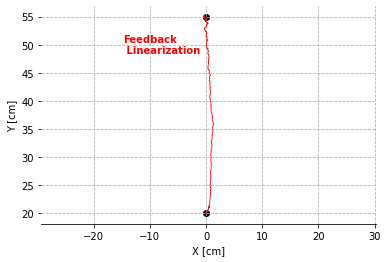

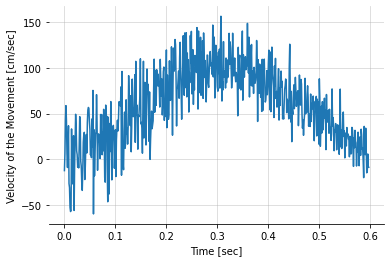

In [4]:
plotFL([0.5,0.5],[0.2,0.2],1e-6)

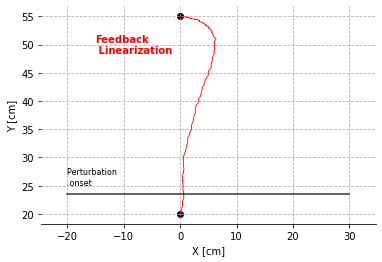

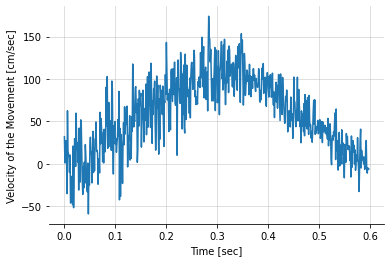

In [5]:
plotFL([-1.5,-0.5],[0.15,0.6],1e-6)

In [6]:
def LQG(Duration,w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,20],ForceField = [0,0],plot = True,ForceFieldSpan = [0,0.6],Noise_Variance = 1e-6):

    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noise in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)
    """
        
    Num_iter = 600
    dt = Duration/Num_iter

    obj1,obj2 = newton(f,df,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(f,df,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    Num_Var = 8
    
    #Define Weight Matrices

    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    A = np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a1+0.025*a3)/((a1-a3)*a3),dt*a1/((a1-a3)*a3),0,dt*(-0.025*a1+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*0.475/(a1-a3),-dt/(a1-a3),0,1-dt*0.475/(a1-a3),dt/(a1-a3),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])

    B = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])
    
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    H,L= np.identity(8),array_L
        
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    array_x_nonlin = np.zeros((Num_iter,Num_Var-2)) 
    y = np.zeros((Num_iter,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0

    x_nonlin = np.zeros(Num_Var-2)
    x_nonlin[0] = x[0]
    x_nonlin[1] = x[3]
    new_x_nonlin = x_nonlin

    sigma = np.identity(Num_Var)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat

    for k in range(Num_iter-1):
        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else 0
        

        x[0],x[1],x[3],x[4] = x_nonlin[0],x_nonlin[2],x_nonlin[1],x_nonlin[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        u = -L[k].reshape(np.flip(B.shape))@xhat
            
        C = np.array([-x_nonlin[3]*(2*x_nonlin[2]+x_nonlin[3])*a2*np.sin(x_nonlin[1]),x_nonlin[2]*x_nonlin[2]*a2*np.sin(x_nonlin[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(x_nonlin[1])*np.cos(x_nonlin[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(x_nonlin[1])-a3)/Denominator],[(-a2*np.cos(x_nonlin[1])-a3)/Denominator,(2*a2*np.cos(x_nonlin[1])+a1)/Denominator]])
        new_x_nonlin[0:2] += dt*x_nonlin[2:4]+motor_noise[:2]
        new_x_nonlin[2:4] += dt*(Minv@(x_nonlin[4:6]-Bdyn@(x_nonlin[2:4])-C))  
        K = 1/0.06
        new_x_nonlin[4:6] += dt*K*(u-x_nonlin[4:6]+F)
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_x_nonlin[k+1] = new_x_nonlin.flatten()
        x_nonlin = new_x_nonlin 
        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    x0 = xstart
    x_nonlin = array_x_nonlin.T[:,1:][:,::1]

    if plot:
        plt.plot(np.cos(x_nonlin[0]+x_nonlin[1])*33+np.cos(x_nonlin[0])*30,np.sin(x_nonlin[0]+x_nonlin[1])*33+np.sin(x_nonlin[0])*30,color = "green",label = "LQG",linewidth = .8)


In [7]:
def plotSimpleMovements(Pert,FSpan,Noise):
    fig,ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    LQG(0.6,1e6,1e6,1e6,1e6,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise)
    X,Y = Feedback_Linearization(0.6,1e8,1e8,1e5,1e5,1e-6,1e-6,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise)
    #plt.legend()
    ax.text(
        10,
        50,
        "LQG",
        color="green",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    ax.text(
        X[50]-15,
        50,
        "Feedback\n Linearization",
        color="red",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    if FSpan[0] != FSpan[1]:
        ax.text(
        -20,
        Y[int(FSpan[0]*1000)]+3,
        "Perturbation \n onset",
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize = 8

        )
        plt.plot(np.linspace(-20,30,1000),np.ones(1000)*Y[int(FSpan[0]/0.001)],color = "black",alpha = .8)
        plt.xlim(-20,30)
    plt.savefig("Presentation_1.png",dpi = 300)
    plt.show()

    fig,ax = plt.subplots()
    plt.grid(alpha = .5)
    plt.xlabel("Time [sec]")
    plt.ylabel("Velocity of the Movement [cm/sec]")
    plt.plot(np.arange(0,0.598,0.001),(Y[1:]-Y[0:len(X)-1])/0.001)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.savefig("Presentation_2.png",dpi = 300)
    plt.show()

In [8]:
def ExploreMovements(Pert,FSpan,Noise):
    fig,ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    LQG(0.6,1e6,1e6,1e6,1e6,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise)
    X,Y = Feedback_Linearization(0.6,1e6,1e6,1e5,1e5,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise)
    #plt.legend()
    ax.text(
        10,
        50,
        "LQG",
        color="green",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    ax.text(
        X[50]-15,
        50,
        "Feedback\n Linearization",
        color="red",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    if FSpan[0] != FSpan[1]:
        ax.text(
        -20,
        Y[20]+3,
        "Perturbation \n onset",
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize = 8

        )
        plt.plot(np.linspace(-20,30,1000),np.ones(1000)*Y[20],color = "black",alpha = .8)
        plt.xlim(-20,30)
        ax.text(
        -20,
        Y[40]+3,
        "Perturbation \n offset",
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize = 8

        )
        plt.plot(np.linspace(-20,30,1000),np.ones(1000)*Y[40],color = "black",alpha = .8)
        plt.xlim(-20,30)
    plt.savefig("Presentation_1.png",dpi = 300)
    plt.show()

    fig,ax = plt.subplots()
    plt.grid(alpha = .5)
    plt.xlabel("Time [sec]")
    plt.ylabel("Velocity of the Movement [cm/sec]")
    plt.plot(np.arange(0,0.598,0.001),(Y[1:]-Y[0:len(X)-1])/0.001)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.savefig("Presentation_2.png",dpi = 300)
    plt.show()

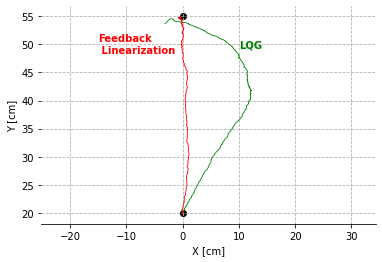

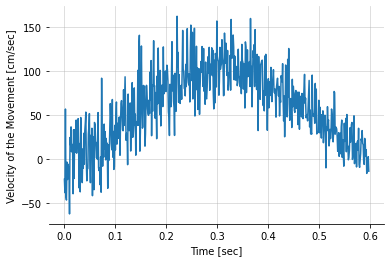

In [9]:
plotSimpleMovements([0.5,0.5],[0.2,0.2],1e-6)

In [10]:
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout.width = '400px'
@widgets.interact(
    t0 = widgets.FloatSlider(0.2, min=0, max=.6, step=.02, layout=my_layout),
    F1 = widgets.FloatSlider(0.5, min=-5, max=5, step=.1, layout=my_layout),
    F2 = widgets.FloatSlider(0.5, min=-5, max=5, step=.1, layout=my_layout),
)

def test_params(t0 =0.2, F1= 0.5, F2 = 0.5):
    plotSimpleMovements([F1,F2],[t0,0.6],1e-6)

interactive(children=(FloatSlider(value=0.2, description='t0', layout=Layout(width='400px'), max=0.6, step=0.0…